# Basic Web Crawling Example

## About
This example contains explanations and code used to perform a basic Web Crawling task. This example will use Python, as it is one of the most popular languages used for Web Scraping/Crawling.

In this example, we will go to the *Looney Tunes Wiki* and crawl through cartoons using page elements. We will do this while scraping data about each cartoon along the way. This knowledge can then be applied to accomplish countless other similar tasks.

**NOTE:** This Jupyter Notebook will be composed of intermittent code and explanations (in markdown). If you just simply want the raw code example, see the bottom of the Jupyter Notebook.

## Install Requirements
First things first, we need to install all of the Python packages we need. In our case, we need the `requests` and `BeautifulSoup` packages. If you don't already have them installed, please go to a terminal in your desired Python Environment and execute the following commands:
- `pip install requests`
- `pip install beautifulsoup4`

## Getting Started
Now that we have all of our packages installed, let's import them:

In [127]:
import requests
from bs4 import BeautifulSoup

The next step we need to do to get started is to determine the webpage where we want to start crawling from. For this example, let's crawl through some of the classic *Looney Tunes* cartoons on the *Looney Tunes Wiki*.

For our example, let's start at the cartoon *Bugs and Thugs*. The URL for this cartoon is: https://looneytunes.fandom.com/wiki/Bugs_and_Thugs

So let's define it as a variable:

In [128]:
# define the starting webpage
url = "https://looneytunes.fandom.com/wiki/Bugs_and_Thugs"

Now let's define our User-Agent string. If you want to learn more about User-Agent strings, you can go check out the previous guide *Example 0: Basic Web Scraping Example*. For this example, I will define a generic User-Agent string:

In [129]:
# define the user-agent string
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.135 Safari/537.36 Edge/12.246'
}

## Extracting the Title

Now, on our starting webpage, open the Developer Tools view of your browser (usually opened with F12). You should now see the HTML hierarchy of the webpage. You can go back to *Example 0: Basic Web Scraping Example* and read the *"Extracting the Title"* section of the guide for more help on how to traverse the elements on the webpage.

By studying the elements on our *Bugs and Thugs* example webpage, we can see that the title of the cartoon is stored in an `h2` element with the *class* name *"pi-item pi-item-spacing pi-title pi-secondary-background"* as seen here:

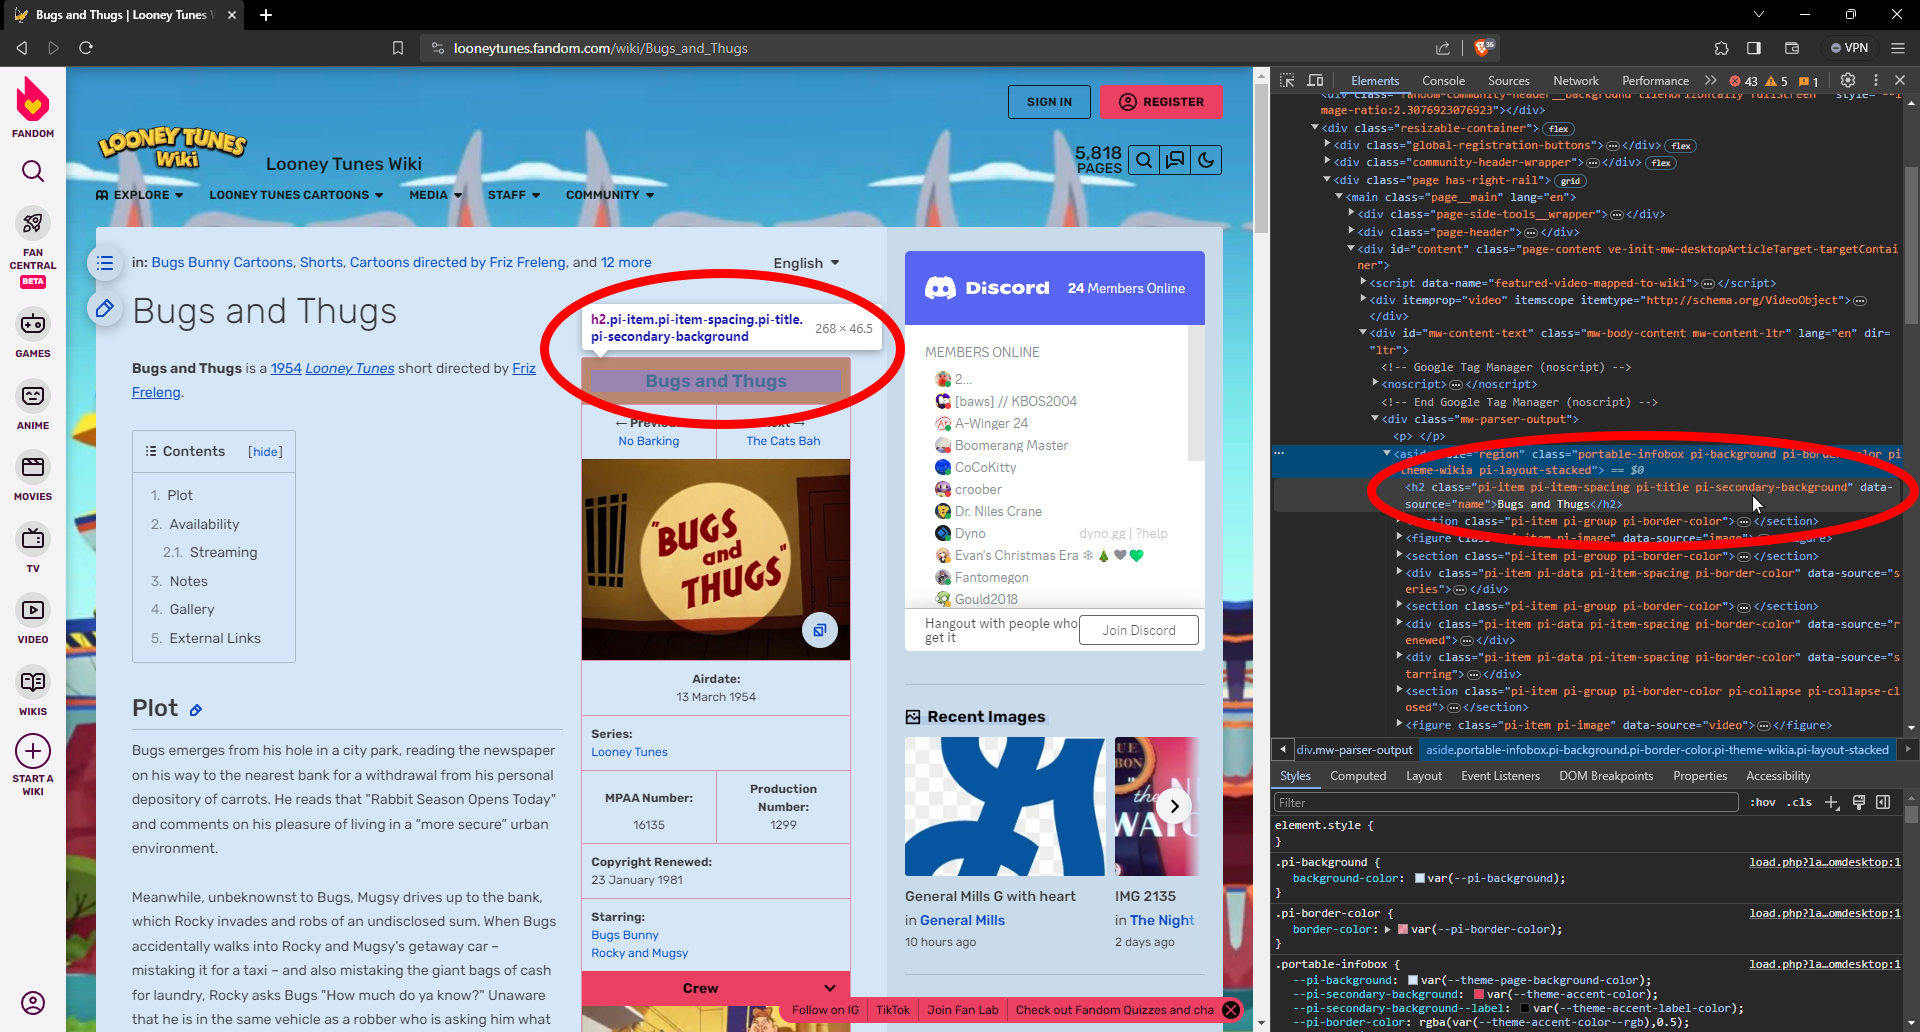

Now that we know this, let's write a function that will accept a cartoon URL and then scrape the Title. Here's one way we can do this:

In [130]:
def scrape_cartoon_title(url):
    # perform the scrape on the target url, provide user-agent string
    response = requests.get(url, headers=headers)

    # ensure the scrape was performed successfully (valid response)
    if response.status_code != 200:
        raise RuntimeError(f"Something may have gone wrong while scraping! The returned status code was: {response.status_code}")

    # pass the webpage data into beautifulsoup for parsing
    soup = BeautifulSoup(response.text, 'html.parser')

    # extract the span containing the cartoon's title
    title_h2 = soup.find("h2", class_="pi-item pi-item-spacing pi-title pi-secondary-background")

    # return the title stored in the .text field
    return title_h2.text

Let's test out our new function. It should accept our `url` variable and print out the title *"Bugs and Thugs"*:

In [131]:
# call our function to get the title of the cartoon
title = scrape_cartoon_title(url)

# print the resulting title
print(title)

Bugs and Thugs


## Extracting the Airdate

Now let's suppose that we want to extract the date that this cartoon originally aired. This data is stored on every cartoon's page on the *Looney Tunes Wiki* under the *"Airdate:"* field.

By studying the HTML structure of the webpage, we can see that the original airdate of the cartoon is stored in a `td` element with the `data-source` *"airdate"* as seen here:

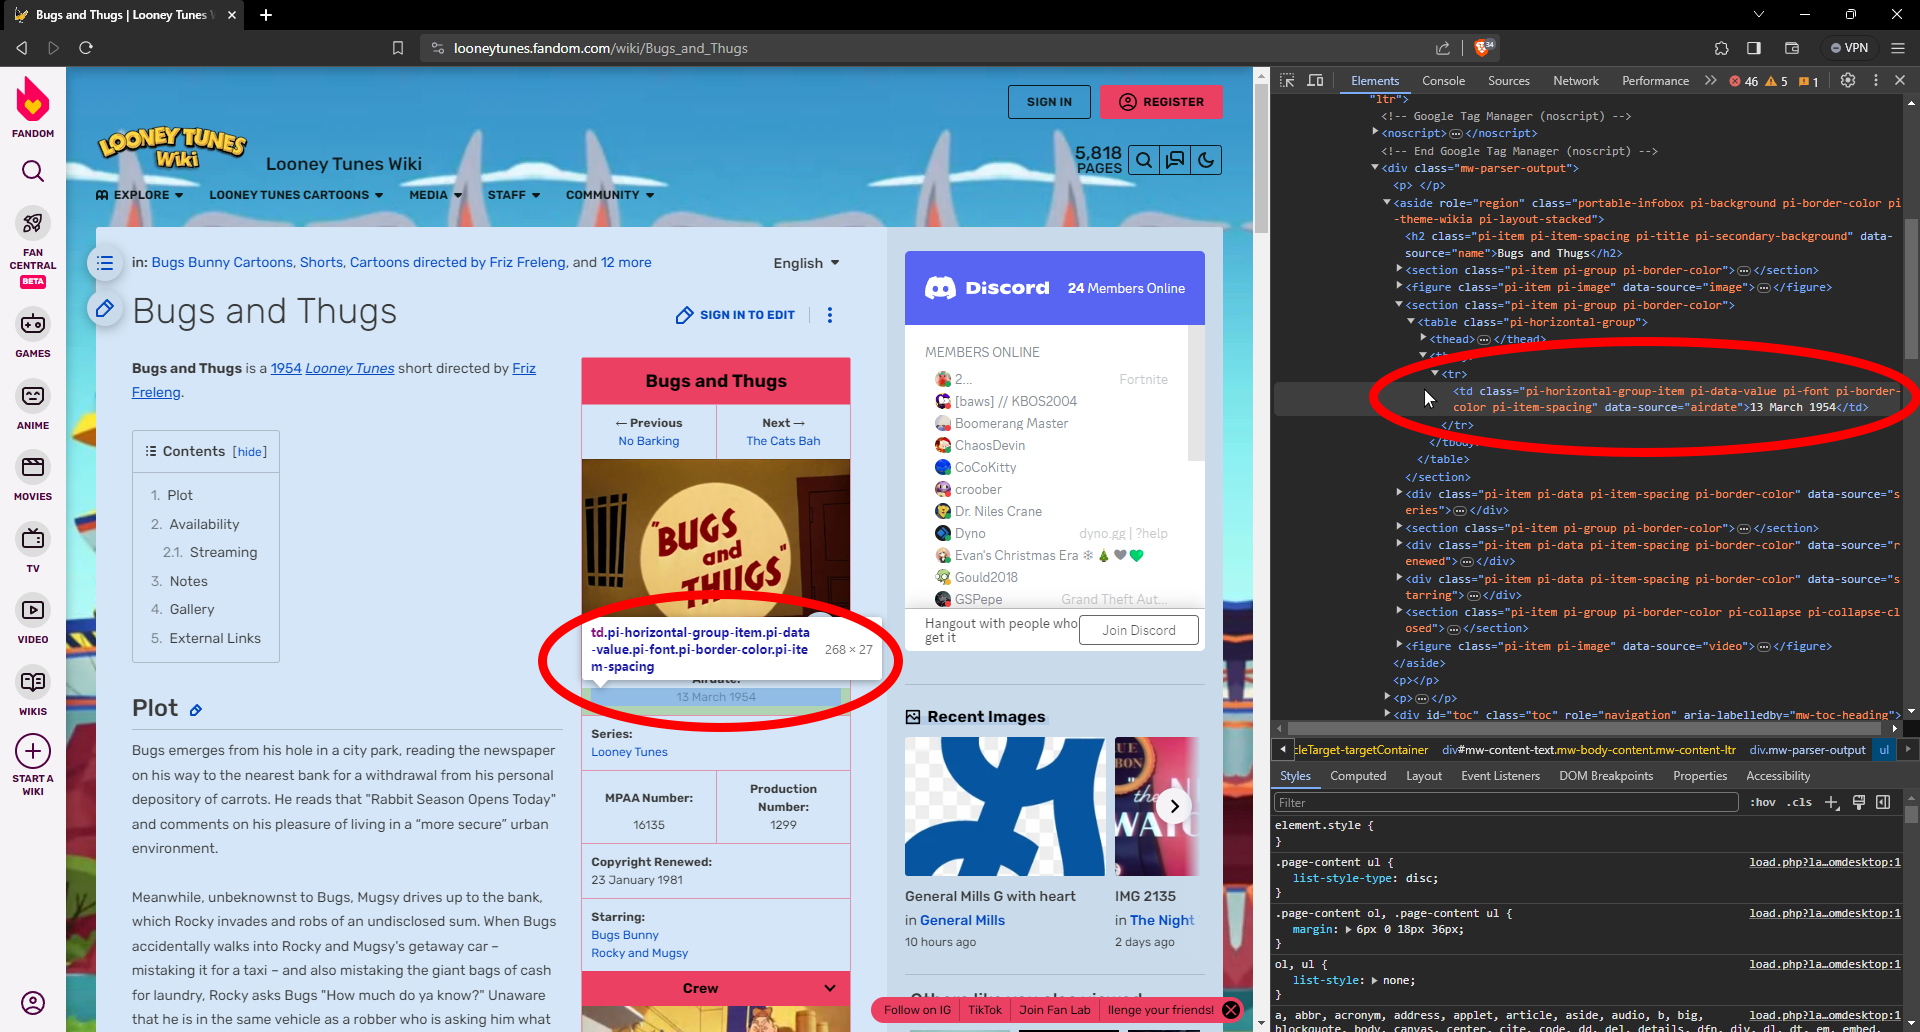

Knowing this, let's update our `scrape_cartoon_title()` to do more than just scrape the title. Let's rename the function to `scrape_cartoon_metadata()` and have it return a list containing the cartoon's title and original airdate. Let's make those changes now:

In [132]:
def scrape_cartoon_metadata(url):
    # perform the scrape on the target url, provide user-agent string
    response = requests.get(url, headers=headers)

    # ensure the scrape was performed successfully (valid response)
    if response.status_code != 200:
        raise RuntimeError(f"Something may have gone wrong while scraping! The returned status code was: {response.status_code}")

    # pass the webpage data into beautifulsoup for parsing
    soup = BeautifulSoup(response.text, 'html.parser')

    # extract title
    title_h2 = soup.find("h2", class_="pi-item pi-item-spacing pi-title pi-secondary-background")
    title = title_h2.text

    # extract airdate
    airdate_td = soup.find("td", attrs={'data-source' : "airdate"})
    airdate = airdate_td.text

    # special note
    # sometimes, the 'airdate' field contains more data than just the original airdate
    # we don't want anything else, so let's perform a manual split to just get the original airdate every time
    # we just want the first 3 elements: <day month year>
    # if you need further explanation on the split() and join() python functions, there are many great resources online
    # from here on out, when we extract the airdate, we'll do a split and join like this:
    airdate = ' '.join(airdate.split(' ')[:3])

    # return list containing the title and original airdate
    return [title, airdate]

Notice that when we extracted the airdate, we didn't use the `class_` argument to search for the containing element by class. Instead, we searched using a different attribute: `data-source`. To search by different attributes, we can use the `attrs` argument to perform the search. In this case we used `attrs={'data-source' : "airdate"}` to search for the element in the page that contains a `data-source` attribute with the value *"airdate".*

Let's test our new function:

In [133]:
print(scrape_cartoon_metadata(url))

['Bugs and Thugs', '13 March 1954']


It works well! Our new function now returns a list containing the cartoon's title and original airdate.

## Extracting the Cast

Let's suppose that we want to extract one last piece of data about each cartoon: the cast. On the *Looney Tunes Wiki*, this data is stored in the *"Starring:"* field. Upon further inspectiong of the HTML structure of the webpage, we can see that the *"Starring:"* field is stored in a `div` element with the `data-source` *"starring"* as seen here:

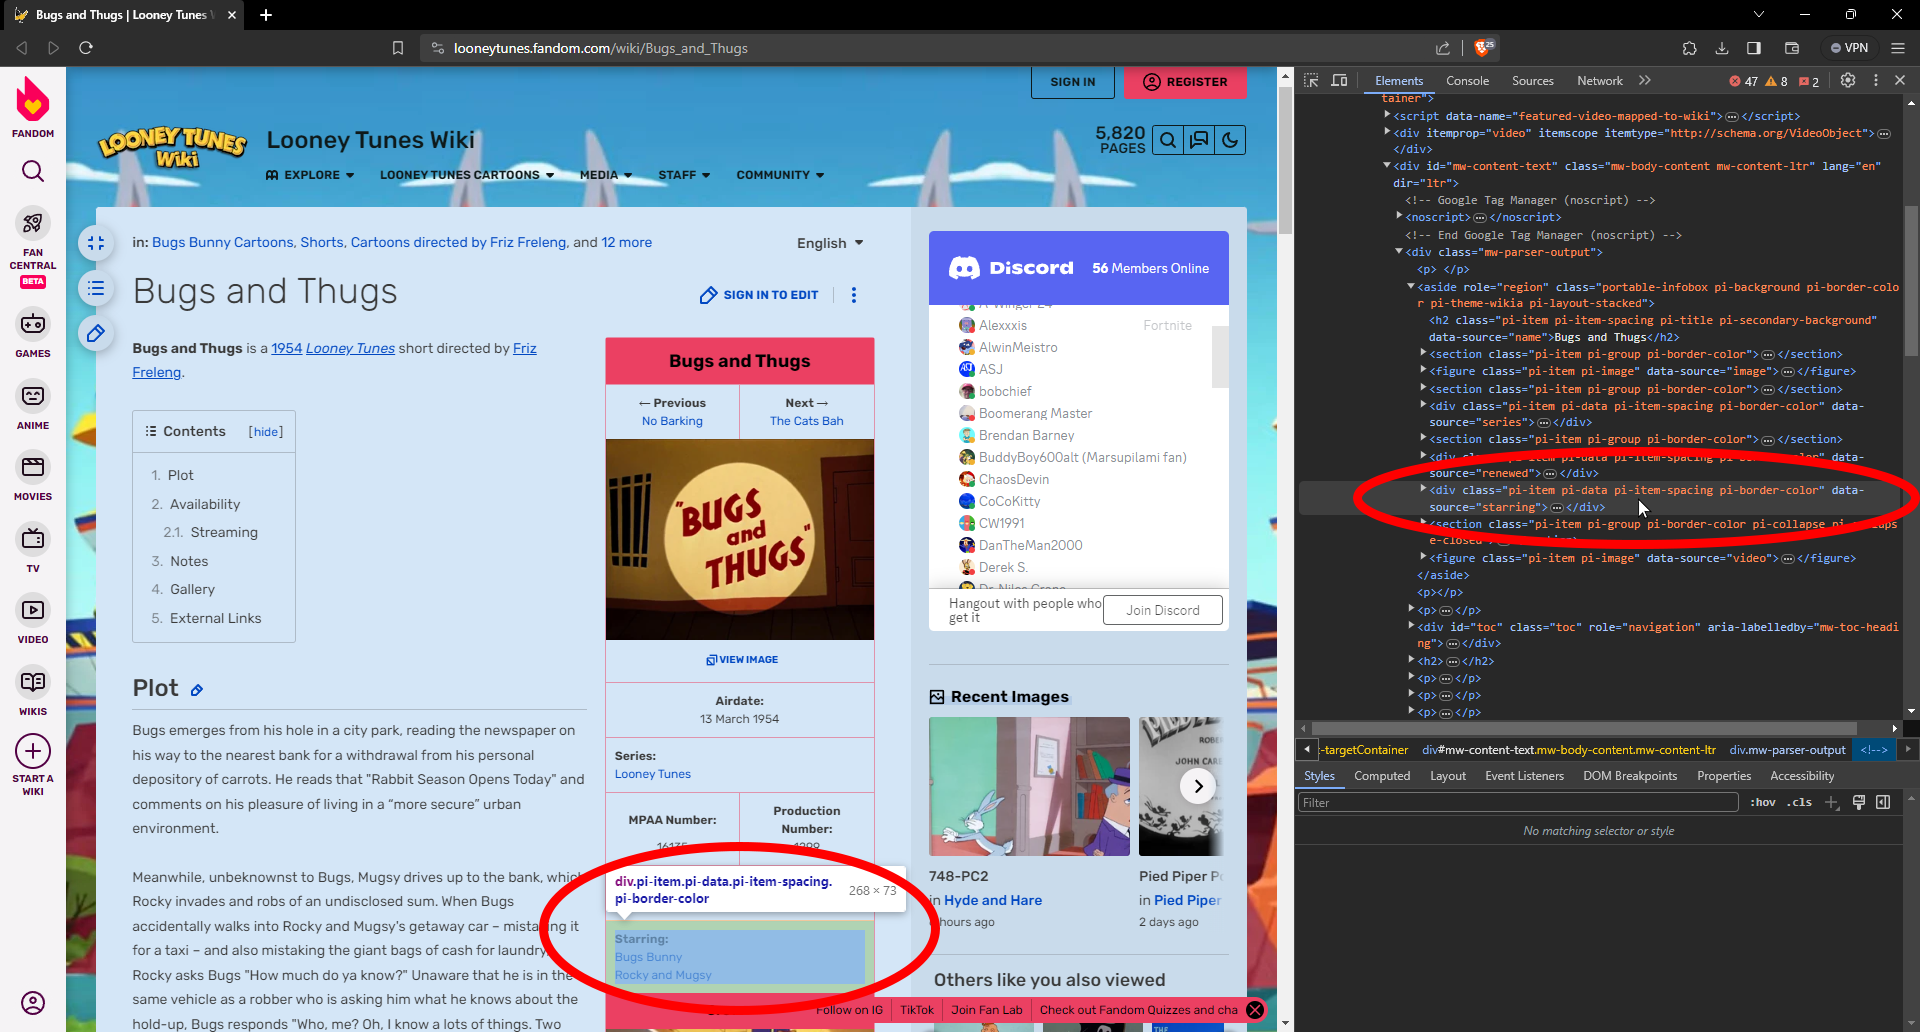

With this knowledge, we can now update our `scrape_cartoon_metadata()` function to extract the cast of the cartoon. To do this, however, we need to rely on a little more programming knowledge than we have used previously.

If we observe the `div` element containing the list of characters in the cartoon, we can see that it has 2 children:
1. `div` containing the text *"Starring:"*
2. `div` containing children `a` elements (each of which corresponds to one character that is listed in the *"Starring:"* field)

This means we need to first select the second child. We can see that the second child has the `class` name *"pi-data-value pi-font"* so we can use that extract it.

Once we have isolated the second child, we can loop through each of its child elements and extract the names of the characters. Notice that each character name is stored in an `a` element as a child to the second child. As we loop through each of the child elements, we need to check if the current child element is an `a` (hyperlink) element. If it is, we can extract the character's name stored in the `text` field of the current child element.

If we use this approach, our code will be able to extract 1 to infinitely many characters that may be listed in the `div`. Ok, now that we've decided our strategy, let's update our function to do it:

In [134]:
def scrape_cartoon_metadata(url):
    # perform the scrape on the target url, provide user-agent string
    response = requests.get(url, headers=headers)

    # ensure the scrape was performed successfully (valid response)
    if response.status_code != 200:
        raise RuntimeError(f"Something may have gone wrong while scraping! The returned status code was: {response.status_code}")

    # pass the webpage data into beautifulsoup for parsing
    soup = BeautifulSoup(response.text, 'html.parser')

    #========================#
    #     extract title      #
    #========================#
    # extract h2 element containing the title
    title_h2 = soup.find("h2", class_="pi-item pi-item-spacing pi-title pi-secondary-background")

    # extract the title text from the h2 element
    title = title_h2.text

    #========================#
    #     extract airdate    #
    #========================#
    # extract td element containing the airdate
    airdate_td = soup.find("td", attrs={'data-source' : "airdate"})

    # extract the airdate text from the td element
    airdate = airdate_td.text

    # ensure we only grab the first three elements in the airdate string
    airdate = ' '.join(airdate.split(' ')[:3])

    #========================#
    #      extract cast      #
    #========================#
    # create empty cast list to store characters
    cast_list = []

    # extract starring div
    starring_div = soup.find("div", attrs={'data-source' : "starring"})

    # extract the second child from the starring_div
    starring_second_child = starring_div.find("div", class_="pi-data-value pi-font")

    # loop through the child elements of the starring_second_child div
    for child in starring_second_child:
        # check if the current child element is an 'a' element
        if (child.name == 'a'):
            # if the current child element is an `a` element, extract the character's name
            # the character's name is stored in the 'text' field of the child
            # save the extracted character's name into our cast_list variable
            cast_list.append(child.text)

    return [title, airdate, cast_list]

Excellent! Now that we've updated our function to extract the cast from the webpage, let's test it out. The function should return three things:
1. Title
2. Airdate
3. A list of the starring characters

In [135]:
cartoon = scrape_cartoon_metadata(url)
print(cartoon)

['Bugs and Thugs', '13 March 1954', ['Bugs Bunny', 'Rocky and Mugsy']]


Perfect! It worked! Now let's write another function that will nicely format and print the cartoon's metadata:

In [136]:
def print_cartoon_metadata(data):
    # extract the metadata into variables
    title    = data[0]
    airdate  = data[1]
    starring = data[2]

    # print the cartoon's title
    print(f"   Title: {title}")

    # print the cartoon's original airdate
    print(f" Airdate: {airdate}")

    # print the cartoon's starring characters
    print(f"Starring: {starring[0]}")
    for character in starring[1:]:
        print(f"          {character}")

    # print final newline to add space (formatting)
    print()

Let's test out our printing function by passing it the cartoon we scraped earlier:

In [137]:
print_cartoon_metadata(cartoon)

   Title: Bugs and Thugs
 Airdate: 13 March 1954
Starring: Bugs Bunny
          Rocky and Mugsy



We now have two functions:
- One that properly scrapes the data we want a from a single cartoon.
- Another that will print out the metadata.

We can now use these two functions for our main task: Web Crawling.

## Web Crawling

Web crawling can take many forms, but in this guide we'll focus on one of its most simple applications. The essential idea behind Web Crawling is to combine Web Scraping (as demonstrated in *0_Basic_Web_Scraping_Example*) with an automated ability to travel, or crawl, through webpages. When Web Scraping is combined with the ability to crawl through pages, it means that we can programatically "browse" through data stored on multiple webpages while saving off the pieces of data that we want along the way.

So let's look at an example of doing this. In the case of this guide based on the *Looney Tunes Wiki*, we could write a Web Crawling program that will scrape the data we want from a single cartoon (as defined above) and then automatically move on to the next webpage and repeat the process. We can crawl through as many pages as we want and save any data that we desire along the way.

To get started, let's consider the means by which we want to travel, or crawl, through the pages. Take a look at this screenshot and notice what's circled in red:

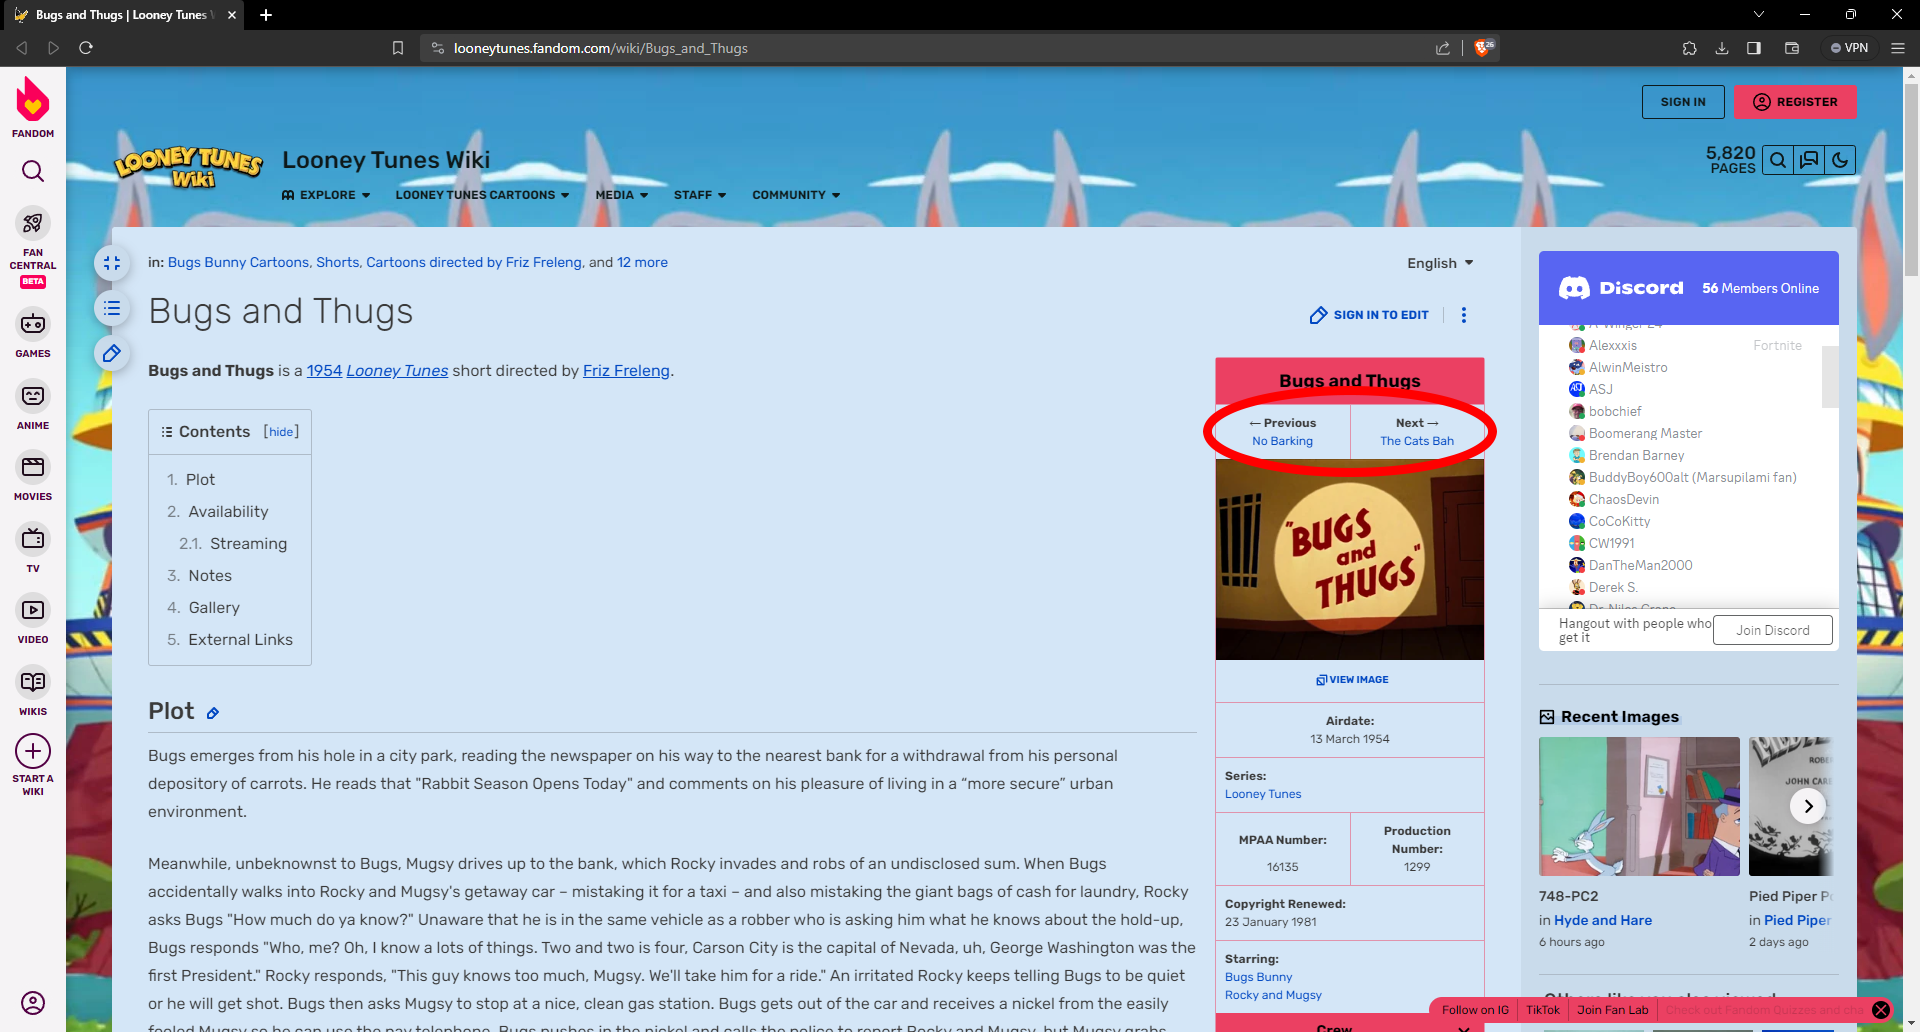

As you can see, there is a *"Next →"* field that contain a hyperlink to the next cartoon's webpage. If you click on that hyperlink, it brings you to the next cartoon's webpage.

So imagine if you were just browsing through this *Looney Tunes Wiki* yourself. When you wanted to go to the next cartoon, you would just click on the *"Next →"* hyperlink, right? Well, the whole idea of web crawling is to automate the process of what you would do to get to the next page. Once you're at the next page, you can scrape whatever data and you want and then go the next page (and so on for as long as you need).

To begin automating the crawling, let's first get the hyperlink stored in the *"Next →"* field. By studying the HTML structure of the webpage, we can see that the *"Next →"* hyperlink is stored in a `td` element with the `data-source` attribute *"next"* as shown here:

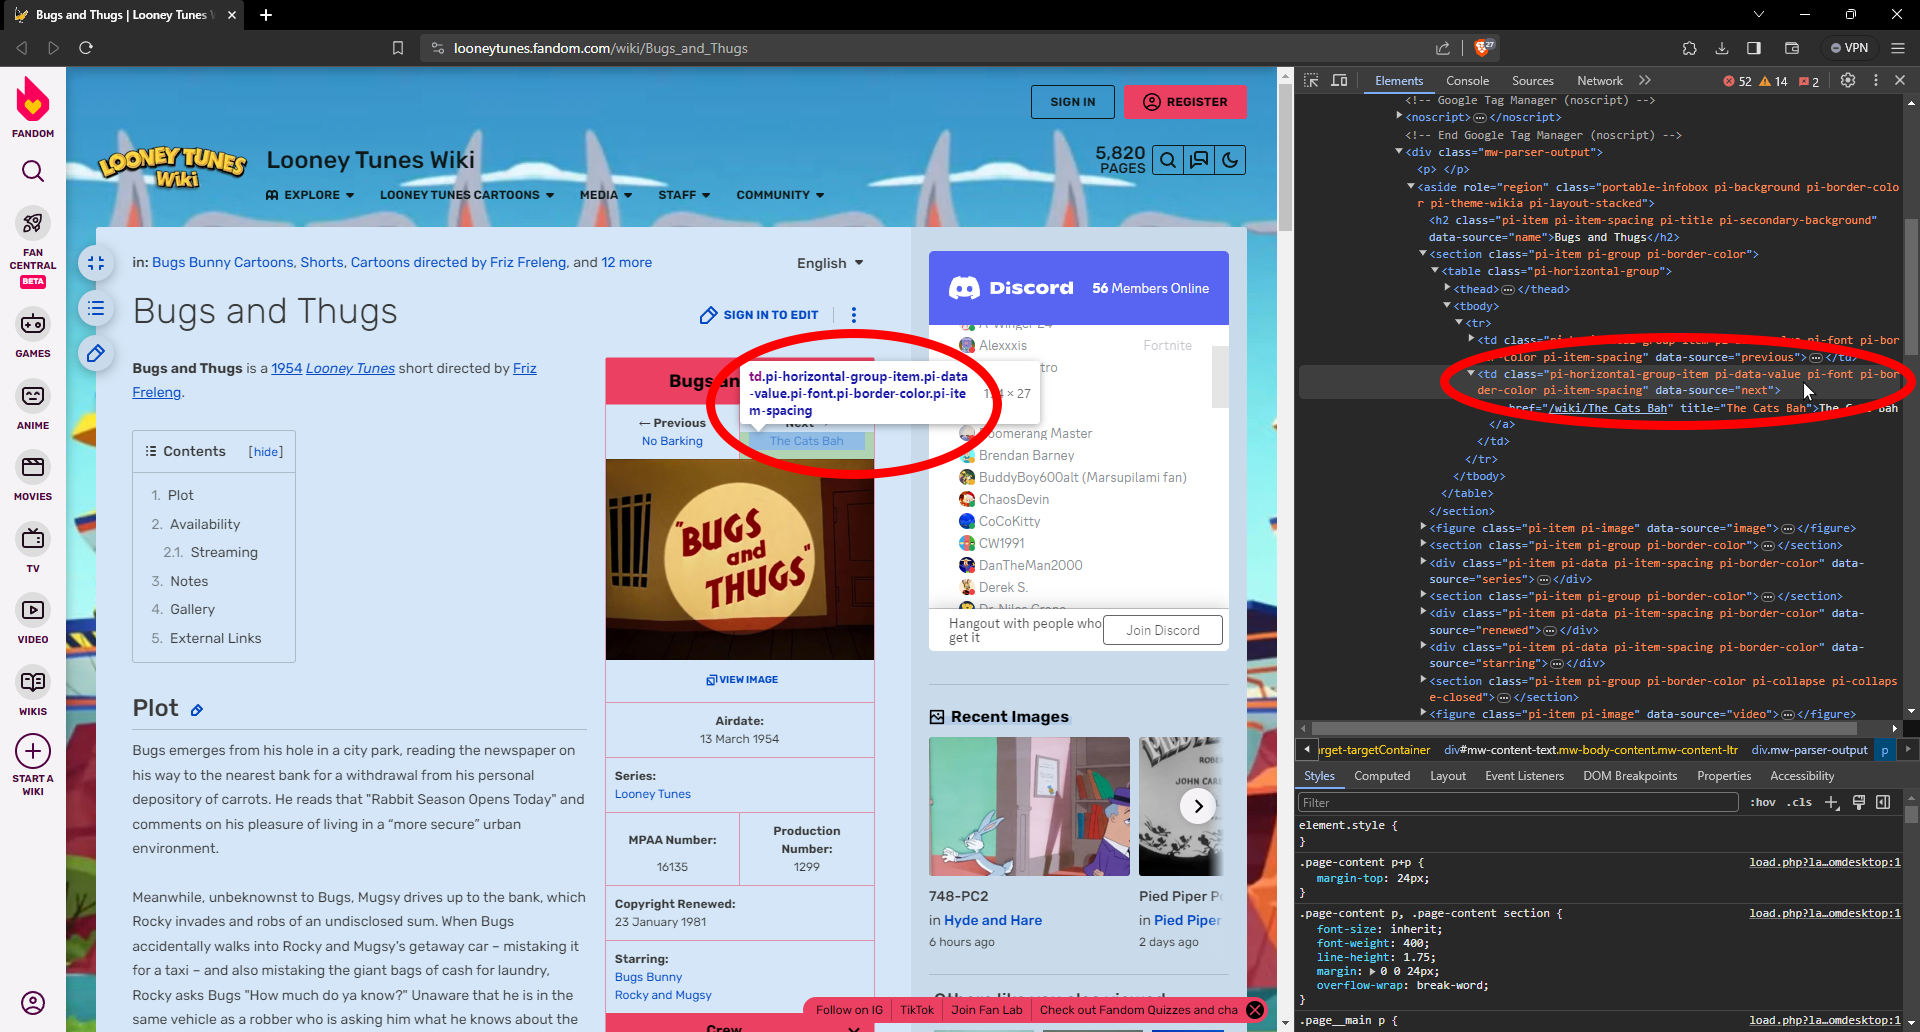

Now that we know this, let's update our `scrape_cartoon_metadata()` function to extract the *"Next →"* hyperlink from the page. In order to do this, we will search for a `td` element in the page with the `data-source` attribute of *"next"*. Once we find it, we need to extract the child element of the `td` that contains the hyperlink. The child element that contains the hyperlink is an `a` element as we can see in the screenshot above.

Once we have extracted the `a` element that contains the hyperlink, we will notice that it is stored inside of the `href` attribute. We can extract that using the `["href"]` accessor.

Once the hyperlink is extracted from the `a` element, however, you'll notice that it is only the end part of the url, or the suffix. That is to say that it is only storing the unique part of the url that will bring you to the next cartoon. This url suffix alone is not enough to formulate a proper url, so we need to concatenate the base url of "https://looneytunes.fandom.com/" with the unique url suffix.

Let's update our function as follows:

In [138]:
def scrape_cartoon_metadata(url):
    # perform the scrape on the target url, provide user-agent string
    response = requests.get(url, headers=headers)

    # ensure the scrape was performed successfully (valid response)
    if response.status_code != 200:
        raise RuntimeError(f"Something may have gone wrong while scraping! The returned status code was: {response.status_code}")

    # pass the webpage data into beautifulsoup for parsing
    soup = BeautifulSoup(response.text, 'html.parser')

    #========================#
    #     extract title      #
    #========================#
    # extract h2 element containing the title
    title_h2 = soup.find("h2", class_="pi-item pi-item-spacing pi-title pi-secondary-background")

    # extract the title text from the h2 element
    title = title_h2.text

    #========================#
    #     extract airdate    #
    #========================#
    # extract td element containing the airdate
    airdate_td = soup.find("td", attrs={'data-source' : "airdate"})

    # extract the airdate text from the td element
    airdate = airdate_td.text

    # ensure we only grab the first three elements in the airdate string
    airdate = ' '.join(airdate.split(' ')[:3])

    #========================#
    #      extract cast      #
    #========================#
    # create empty cast list to store characters
    cast_list = []

    # extract starring div
    starring_div = soup.find("div", attrs={'data-source' : "starring"})

    # extract the second child from the starring_div
    starring_second_child = starring_div.find("div", class_="pi-data-value pi-font")

    # loop through the child elements of the starring_second_child div
    for child in starring_second_child:
        # check if the current child element is an 'a' element
        if (child.name == 'a'):
            # if the current child element is an `a` element, extract the character's name
            # the character's name is stored in the 'text' field of the child
            # save the extracted character's name into our cast_list variable
            cast_list.append(child.text)

    #========================#
    # extract next hyperlink #
    #========================#
    # extract td element containing the next hyperlink
    next_hyperlink_td = soup.find("td", attrs={'data-source' : "next"})

    # extract the 'a' child element containing the next hyperlink
    a_next_hyperlink = next_hyperlink_td.find("a")

    # extract the hyperlink from the 'a' element
    hyperlink = a_next_hyperlink["href"]

    # concatenate website url with the suffix of the next hyperlink
    next_hyperlink = "https://looneytunes.fandom.com" + hyperlink

    # return list of results
    return [title, airdate, cast_list, next_hyperlink]

Great! Now that we have our function updated, let's test it out. With our new changes, our `scrape_cartoon_metadata()` function will now return 4 things:
1. Title
2. Airdate
3. Cast
4. *"Next →"* hyperlink (url to the next cartoon we want to scrape)

Let's see it in action:

In [139]:
scrape_cartoon_metadata(url)

['Bugs and Thugs',
 '13 March 1954',
 ['Bugs Bunny', 'Rocky and Mugsy'],
 'https://looneytunes.fandom.com/wiki/The_Cats_Bah']

It worked! Try clicking the *"Next →"* hyperlink that our function returned (or copy it and paste it into your web browser if necessary). That url should open the next cartoon on the *Looney Tunes Wiki*, which is *The Cats Bah*

This means that we have succesfully scraped all of the data we want about our starting cartoon (*Bugs and Thugs*) and have also obtained the url of the cartoon we want to scrape next (*The Cats Bah*).

Now that we have the url of the cartoon we want to scrape next, let's try scraping data about the 2 cartoons: *Bugs and Thugs* and *The Cats Bah*

After we scrape the data from both cartoons, let's print them out nicely using the `print_cartoon_metadata()` function we defined earlier:

In [140]:
# scrape the BUGS AND THUGS cartoon metadata from the Looney Tunes Wiki
# remember that the "url" variable contains our starting url (of BUGS AND THUGS)
bugs_and_thugs = scrape_cartoon_metadata(url)

# nicely print out the BUGS AND THUGS cartoon metadata
# using the function we defined earlier
print_cartoon_metadata(bugs_and_thugs)

# extract the next url we want to scrape from the returned bugs_and_thugs list
# remember that the next url is the 4th element in the list we return from scrape_cartoon_metadata()
the_cats_bah_url = bugs_and_thugs[3]

# scrape the THE CATS BAH cartoon metadata from the Looney Tunes Wiki
the_cats_bah = scrape_cartoon_metadata(the_cats_bah_url)

# nicely print out the THE CATS BAH cartoon metadata
# using the function we defined earlier
print_cartoon_metadata(the_cats_bah)

   Title: Bugs and Thugs
 Airdate: 13 March 1954
Starring: Bugs Bunny
          Rocky and Mugsy

   Title: The Cats Bah
 Airdate: 20 March 1954
Starring: Pepé Le Pew
          Penelope Pussycat



Excellent! It worked. Now that we see how to scrape the data from the starting cartoon and get the url for the next one (in the same step), we can do this process over and over. We could manually do it ourselves, but because it's the same process every time, we just can just write a loop that will automate it for us.

So let's dive in and write a loop that will begin with our starting cartoon (*Bugs and Thugs*) and then scrape the next 4 cartoons that come after it. So, our goal is to print 5 cartoons total with only one loop.

Let's hop in:

In [141]:
# save off the starting cartoon url into a new variable that will be used inside the loop
cartoon_url = url

# create a loop that will run 5 times
for i in range(5):
    # scrape the metadata of the current cartoon
    cartoon_metadata = scrape_cartoon_metadata(cartoon_url)

    # nicely print the metadata of the current cartoon
    print_cartoon_metadata(cartoon_metadata)

    # extract the next cartoon url from the current cartoon's metadata
    # remember: the next url is stored in the 4th element of the metadata (index 3)
    next_url = cartoon_metadata[3]

    # set the current cartoon url to the next url for the next iteration of the loop
    cartoon_url = next_url

   Title: Bugs and Thugs
 Airdate: 13 March 1954
Starring: Bugs Bunny
          Rocky and Mugsy

   Title: The Cats Bah
 Airdate: 20 March 1954
Starring: Pepé Le Pew
          Penelope Pussycat

   Title: Design for Leaving
 Airdate: 27 March 1954
Starring: Daffy Duck
          Elmer Fudd

   Title: Bell Hoppy
 Airdate: 17 April 1954
Starring: Sylvester
          Hippety Hopper
          Loyal Order Grand Master

   Title: No Parking Hare
 Airdate: 1 May 1954
Starring: Bugs Bunny



Excellent! It worked flawlessly.

Now let's supposed that we want to scrape 10 cartoons total, starting with *Bugs and Thugs*. Rather than continuing to create loops with specific numbers of iterations, let's just create a function that accepts a url of a cartoon and the number of cartoons you want to scrape. This way we can modularize this function to be used anywhere without having to write custom loops every time.

Let's write that function now:

In [142]:
def scrape_and_print_cartoons(cartoon_url, num_of_cartoons):
    # create a loop that will run for the given num_of_cartoons
    for i in range(num_of_cartoons):
        # scrape the metadata of the current cartoon
        cartoon_metadata = scrape_cartoon_metadata(cartoon_url)

        # nicely print the metadata of the current cartoon
        print_cartoon_metadata(cartoon_metadata)

        # extract the next cartoon url from the current cartoon's metadata
        # remember: the next url is stored in the 4th element of the metadata (index 3)
        next_url = cartoon_metadata[3]

        # set the current cartoon url to the next url for the next iteration of the loop
        cartoon_url = next_url

Alright, now that this function is written, let's test it out.

If we provide our new function the *Bugs and Thugs* url and the number 10, it should start at *Bugs and Thugs* and then scrape nine additional cartoons. All 10 cartoons will be printed out nicely.

Let's test it out:

In [143]:
# scrape and print 10 cartoons, starting with BUGS AND THUGS
scrape_and_print_cartoons(url, 10)

   Title: Bugs and Thugs
 Airdate: 13 March 1954
Starring: Bugs Bunny
          Rocky and Mugsy

   Title: The Cats Bah
 Airdate: 20 March 1954
Starring: Pepé Le Pew
          Penelope Pussycat

   Title: Design for Leaving
 Airdate: 27 March 1954
Starring: Daffy Duck
          Elmer Fudd

   Title: Bell Hoppy
 Airdate: 17 April 1954
Starring: Sylvester
          Hippety Hopper
          Loyal Order Grand Master

   Title: No Parking Hare
 Airdate: 1 May 1954
Starring: Bugs Bunny

   Title: Dr. Jerkyl's Hide
 Airdate: 8 May 1954
Starring: Sylvester
          Alf
          Chester

   Title: Claws for Alarm
 Airdate: 22 May 1954
Starring: Porky Pig
          Sylvester

   Title: Little Boy Boo
 Airdate: 5 June 1954
Starring: Foghorn Leghorn
          Miss Prissy
          Egghead Jr.

   Title: Devil May Hare
 Airdate: 19 June 1954
Starring: Bugs Bunny
          Tasmanian Devil
          Tasmanian She-Devil

   Title: Muzzle Tough
 Airdate: 26 June 1954
Starring: Sylvester
          Twe

Great! It worked perfectly.

This concludes the basic web crawling guide. Now you have a simple, working example of web crawling. This is only one application of web crawling. Now you can take this knowledge and apply it to an infinite array of uses. It's a powerful tool and allows web scraping to become a more intelligent, automated concept.

# Raw Code Example

As stated in the *"About"* section above, here is the raw code example (without accompanying explanations of steps):

In [144]:
import requests
from bs4 import BeautifulSoup


# define the starting webpage
url = "https://looneytunes.fandom.com/wiki/Bugs_and_Thugs"

# define the user-agent string
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.135 Safari/537.36 Edge/12.246'
}

def print_cartoon_metadata(data):
    # extract the metadata into variables
    title    = data[0]
    airdate  = data[1]
    starring = data[2]

    # print the cartoon's title
    print(f"   Title: {title}")

    # print the cartoon's original airdate
    print(f" Airdate: {airdate}")

    # print the cartoon's starring characters
    print(f"Starring: {starring[0]}")
    for character in starring[1:]:
        print(f"          {character}")

    # print final newline to add space (formatting)
    print()

def scrape_cartoon_metadata(url):
    # perform the scrape on the target url, provide user-agent string
    response = requests.get(url, headers=headers)

    # ensure the scrape was performed successfully (valid response)
    if response.status_code != 200:
        raise RuntimeError(f"Something may have gone wrong while scraping! The returned status code was: {response.status_code}")

    # pass the webpage data into beautifulsoup for parsing
    soup = BeautifulSoup(response.text, 'html.parser')

    #========================#
    #     extract title      #
    #========================#
    # extract h2 element containing the title
    title_h2 = soup.find("h2", class_="pi-item pi-item-spacing pi-title pi-secondary-background")

    # extract the title text from the h2 element
    title = title_h2.text

    #========================#
    #     extract airdate    #
    #========================#
    # extract td element containing the airdate
    airdate_td = soup.find("td", attrs={'data-source' : "airdate"})

    # extract the airdate text from the td element
    airdate = airdate_td.text

    # ensure we only grab the first three elements in the airdate string
    airdate = ' '.join(airdate.split(' ')[:3])

    #========================#
    #      extract cast      #
    #========================#
    # create empty cast list to store characters
    cast_list = []

    # extract starring div
    starring_div = soup.find("div", attrs={'data-source' : "starring"})

    # extract the second child from the starring_div
    starring_second_child = starring_div.find("div", class_="pi-data-value pi-font")

    # loop through the child elements of the starring_second_child div
    for child in starring_second_child:
        # check if the current child element is an 'a' element
        if (child.name == 'a'):
            # if the current child element is an `a` element, extract the character's name
            # the character's name is stored in the 'text' field of the child
            # save the extracted character's name into our cast_list variable
            cast_list.append(child.text)

    #========================#
    # extract next hyperlink #
    #========================#
    # extract td element containing the next hyperlink
    next_hyperlink_td = soup.find("td", attrs={'data-source' : "next"})

    # extract the 'a' child element containing the next hyperlink
    a_next_hyperlink = next_hyperlink_td.find("a")

    # extract the hyperlink from the 'a' element
    hyperlink = a_next_hyperlink["href"]

    # concatenate website url with the suffix of the next hyperlink
    next_hyperlink = "https://looneytunes.fandom.com" + hyperlink

    return [title, airdate, cast_list, next_hyperlink]

def scrape_and_print_cartoons(cartoon_url, num_of_cartoons):
    # create a loop that will run for the given num_of_cartoons
    for i in range(num_of_cartoons):
        # scrape the metadata of the current cartoon
        cartoon_metadata = scrape_cartoon_metadata(cartoon_url)

        # nicely print the metadata of the current cartoon
        print_cartoon_metadata(cartoon_metadata)

        # extract the next cartoon url from the current cartoon's metadata
        # remember: the next url is stored in the 4th element of the metadata (index 3)
        next_url = cartoon_metadata[3]

        # set the current cartoon url to the next url for the next iteration of the loop
        cartoon_url = next_url

# scrape and print 10 cartoons, starting with BUGS AND THUGS
scrape_and_print_cartoons(url, 10)

   Title: Bugs and Thugs
 Airdate: 13 March 1954
Starring: Bugs Bunny
          Rocky and Mugsy

   Title: The Cats Bah
 Airdate: 20 March 1954
Starring: Pepé Le Pew
          Penelope Pussycat

   Title: Design for Leaving
 Airdate: 27 March 1954
Starring: Daffy Duck
          Elmer Fudd

   Title: Bell Hoppy
 Airdate: 17 April 1954
Starring: Sylvester
          Hippety Hopper
          Loyal Order Grand Master

   Title: No Parking Hare
 Airdate: 1 May 1954
Starring: Bugs Bunny

   Title: Dr. Jerkyl's Hide
 Airdate: 8 May 1954
Starring: Sylvester
          Alf
          Chester

   Title: Claws for Alarm
 Airdate: 22 May 1954
Starring: Porky Pig
          Sylvester

   Title: Little Boy Boo
 Airdate: 5 June 1954
Starring: Foghorn Leghorn
          Miss Prissy
          Egghead Jr.

   Title: Devil May Hare
 Airdate: 19 June 1954
Starring: Bugs Bunny
          Tasmanian Devil
          Tasmanian She-Devil

   Title: Muzzle Tough
 Airdate: 26 June 1954
Starring: Sylvester
          Twe